In [19]:
import torch
import numpy as np
import torch.nn as nn

class SensoryNeurons(nn.Module):
    
    def __init__(self, num_neurons, in_dim = 1, plastic = True, params = (5, -2.5)):
        super(SensoryNeurons, self).__init__()
        
        self.in_dim = in_dim
        self.plastic = plastic
        self.params = params
        self.num_neurons = num_neurons

        self.linear = nn.Linear(self.in_dim,self.num_neurons, bias = True)
        self.resp_func = nn.Sigmoid()

        if not self.plastic:
            self.set_linear_weights()
            self.linear.weight.requires_grad = False
        
    def set_linear_weights(self):
        
        self.linear.weight = torch.nn.Parameter(data = self.params[0] + 0.2*torch.randn(self.num_neurons,1), requires_grad = False)
        self.linear.bias = torch.nn.Parameter(data = self.params[1] + 0.2*torch.randn(self.num_neurons), requires_grad = False)

    
    def forward(self, x):
        
        x = self.linear(x)
        x = self.resp_func(x)
        
        return x
        
        
        
class SensoryPopulation(nn.Module):
    def __init__(self, num_neurons, plastic = True, population_ratio = 0.5):
        super(SensoryPopulation, self).__init__()
        
        self.num_neurons = num_neurons
        self.plastic = plastic
        self.num_neurons_group1 = round(self.num_neurons * population_ratio)
        self.num_neurons_group2 = round(self.num_neurons * (1.0 - population_ratio))
        self.sensory_neurons_1 = SensoryNeurons(num_neurons = self.num_neurons_group1, in_dim = 1, plastic = self.plastic, params = (5, -2.5))
        self.sensory_neurons_2 = SensoryNeurons(num_neurons = self.num_neurons_group2, in_dim = 1, plastic = self.plastic, params = (-5, -2.5))
        
    def forward(self,x):
        
        x1 = self.sensory_neurons_1(x)
        x2 = self.sensory_neurons_2(x)
        
        out = torch.cat((x1, x2),dim = 1)       
        
        return out
            
        
    
class Readout(nn.Module):
    def __init__(self,num_classes = 2, in_dim = 10):
        super(Readout, self).__init__()
        
        self.num_classes = num_classes
        self.in_dim = in_dim
        
        self.readout_layer = nn.Linear(self.in_dim, self.num_classes, bias = True)
        self._set_weights()
        
    def _set_weights(self):
        self.readout_layer.weight = nn.Parameter(torch.ones(self.readout_layer.weight.shape),requires_grad=False) #
        
    def forward(self, x):
        
        return (self.readout_layer(x))
    
    
class Sensorimotor(nn.Module):
    def __init__(self, num_sensory_neurons = 10, sensory_plastic = True, sensory_pop_ratio = 0.5, num_classes = 2):
        super(Sensorimotor, self).__init__()
        
        self.sensory_pop = SensoryPopulation(num_neurons = num_sensory_neurons, plastic = sensory_plastic, population_ratio = sensory_pop_ratio)
        self.readout = Readout(num_classes = num_classes, in_dim = num_sensory_neurons)
        self.sig = nn.Sigmoid()
#         self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        sensory_out = self.sensory_pop(x)
        readout_out = self.readout(sensory_out)
        y = self.sig(readout_out)
#         y = self.softmax(readout_out)
#         y = readout_out
        
        return y, readout_out
        
        
    

In [20]:
from torch.utils import data

class Stimulus(data.DataLoader):
    def __init__(self, min_coherence = 0.8, max_coherence = 1):
        
        self.min_coherence = min_coherence
        self.max_coherence = max_coherence
        
        self.NUM_SAMPLPES_PER_CATEGORY = 1000
        
        data1 = torch.rand(self.NUM_SAMPLPES_PER_CATEGORY)*(self.max_coherence - self.min_coherence) + self.min_coherence
        data2 = -(torch.rand(self.NUM_SAMPLPES_PER_CATEGORY)*(self.max_coherence - self.min_coherence) + self.min_coherence)
#         target1 = torch.zeros(data1.shape, dtype = int)
#         target2 = torch.ones(data2.shape, dtype = int)
        target1 = torch.zeros(data1.shape)
        target2 = torch.ones(data2.shape)
        
        self.data = torch.cat((data1, data2), dim = 0).unsqueeze(0).t()
        self.target = torch.cat((target1, target2), dim = 0).unsqueeze(0).t()
 
    def __getitem__(self, index):
        
        
        return (self.data[index], self.target[index])
    
    def __len__(self):
        
        return len(self.data)
    
     
        
        

In [21]:



class ConfusionMeter(object):
    '''compute and show confusion matrix'''
    def __init__(self, num_class):
        self.num_class = num_class
        self.mat = np.zeros((num_class, num_class))
        self.precision = []
        self.recall = []

    def update(self, pred, tar):
        pred, tar = pred.cpu().numpy(), tar.cpu().numpy()
        pred = np.squeeze(pred)
        tar = np.squeeze(tar)
        for p,t in zip(pred.flat, tar.flat):
            self.mat[p][t] += 1

    def print_mat(self):
        print('Confusion Matrix: (target in columns)')
        print(self.mat)

    def plot_mat(self, path, dictionary=None, annotate=False):
        plt.figure(dpi=600)
        plt.imshow(self.mat,
            cmap=plt.cm.jet,
            interpolation=None,
            extent=(0.5, np.shape(self.mat)[0]+0.5, np.shape(self.mat)[1]+0.5, 0.5))
        width, height = self.mat.shape
        if annotate:
            for x in range(width):
                for y in range(height):
                    plt.annotate(str(int(self.mat[x][y])), xy=(y+1, x+1),
                                 horizontalalignment='center',
                                 verticalalignment='center',
                                 fontsize=8)

        if dictionary is not None:
            plt.xticks([i+1 for i in range(width)],
                       [dictionary[i] for i in range(width)],
                       rotation='vertical')
            plt.yticks([i+1 for i in range(height)],
                       [dictionary[i] for i in range(height)])
        plt.xlabel('Ground Truth')
        plt.ylabel('Prediction')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(path, format='svg')
        plt.clf()

        # for i in range(width):
        #     if np.sum(self.mat[i,:]) != 0:
        #         self.precision.append(self.mat[i,i] / np.sum(self.mat[i,:]))
        #     if np.sum(self.mat[:,i]) != 0:
        #         self.recall.append(self.mat[i,i] / np.sum(self.mat[:,i]))
        # print('Average Precision: %0.4f' % np.mean(self.precision))
        # print('Average Recall: %0.4f' % np.mean(self.recall))



In [32]:
from torch.utils import data
import torch.optim as optim

def main(num_epochs = 1000, lr = 1e-1, batch_size = 100, learning_rule = 'backprop', model = None): # learning_rule can be 'backprop' or 'global_gain'
    
    if model is None:
        model = Sensorimotor(num_sensory_neurons = 100, 
                             sensory_plastic = False, 
                             sensory_pop_ratio = 0.5,
                             num_classes = 1)
    
    print(model)
    print(model.readout.readout_layer.weight)
    print('\n===========Check Grad============')
    for name, param in model.named_parameters():
        print(name, param.requires_grad)
    print('=================================\n')    
    
    params = model.parameters()
    
    
    optimizer = optim.SGD(params, lr=lr, momentum=0, dampening=0, weight_decay=0, nesterov=False)
#     loss = nn.CrossEntropyLoss()
#     loss = nn.NLLLoss()
#     loss = nn.MSELoss()
    loss = nn.BCELoss(reduction='mean')
    
    dataset_train = Stimulus(min_coherence = 0.8, max_coherence = 1) # set the range of coherences
    dataset_valid = Stimulus(min_coherence = 0.8, max_coherence = 1)
#     dataset_valid = Stimulus(min_coherence = 0.04, max_coherence = 0.06)


    sampler_train = data.RandomSampler(dataset_train)
    train_dl = data.DataLoader(dataset_train,
                             batch_size=batch_size,
                             sampler=sampler_train,
                             shuffle=False,
                             num_workers=0,
                             pin_memory=True,
                             drop_last=True)
    
    sampler_valid = data.RandomSampler(dataset_valid)
    valid_dl = data.DataLoader(dataset_valid,
                             batch_size=batch_size,
                             sampler=sampler_valid,
                             shuffle=False,
                             num_workers=0,
                             pin_memory=True,
                             drop_last=True)
    


    all_loss = []
    all_loss_valid = []
    
    
    for epoch in range(num_epochs):
        Loss = 0
        
        for stimulus, target in train_dl:
            
            decision, _ = model(stimulus)
            L = loss(decision, target.squeeze())
#             print(f'dec={decision}, t={target.squeeze()}, loss={L}')
            Loss += L/len(train_dl)
            optimizer.zero_grad()
            L.backward()      
            
            if learning_rule != 'backprop':
                model = personalized_backward(model, stimulus, target, method=learning_rule)

            
            optimizer.step()
            del L
            
            
        Loss_valid = 0
        conf_mat = ConfusionMeter(num_class=2)
        i = 0
        y1 = []
        y0 = []
        for stimulus, target in valid_dl:
            
            with torch.no_grad():
                decision, readout = model(stimulus)
                
                pred = decision.clone()

                
                decision_copy = decision.clone()
                pred = target.clone()
#                 y1.extend(readout[:,1].detach())
#                 y0.extend(readout[:,0].detach())
#                 idx1 = decision_copy[:,1] < decision_copy[:,0]
#                 idx2 = decision_copy[:,1] >= decision_copy[:,0]
                idx1 = decision_copy < 0.5
                idx2 = decision_copy >= 0.5
                pred[idx1] = 0
                pred[idx2] = 1

                target_copy = target.squeeze().int()
                conf_mat.update(pred.int(),target_copy)
                del pred
                L = loss(decision, target.squeeze())
                Loss_valid += L/len(train_dl)
                
#                 

                del L
        if epoch == 0:
            conf_mat.print_mat()
            
        all_loss.append(Loss)
        all_loss_valid.append(Loss_valid)
        
    conf_mat.print_mat()
    print(model.readout.readout_layer.weight)


        # print(f'epoch {epoch},   training Loss = {Loss},   validation Loss = {Loss_valid}')
    return all_loss, all_loss_valid, model, y0, y1
            
            
def personalized_backward(model, stimulus, target, method = 'global_gain'):
    
    if method == 'global_gain': 
        # only adds to the weight value:  if weight is negative (positive) adds a negative (positive) value 
        for n,p in model.named_parameters():

            if p.requires_grad:
#                 print(f'{n}, mean = {p.mean()}, std = {p.std()}')
                p_sign = p.clone()
                p_sign[p_sign>0] = 1
                p_sign[p_sign<0] = -1
                p.grad = -1*torch.ones((p.grad.shape),requires_grad=True)*p_sign
    
    if method == 'hebbian': 
        
        for n,p in model.named_parameters():
            
            if ('readout' in n) and ('weight' in n):
                output = model(stimulus)
                s_out = model.sensory_pop(stimulus)
                hebb_factor = torch.matmul(output.transpose(1,0),s_out)/s_out.shape[0]
                p.grad = hebb_factor
        
    if method == 'hebbian_wfb':
        
        for n,p in model.named_parameters():
            
            if ('readout' in n) and ('weight' in n):
                target = target.unsqueeze(0)
                
                # create feedback based on the target values
                fb = torch.cat((target,(target-1).abs()),dim=0).squeeze().transpose(1,0)
                
                output = model(stimulus)
                fb_modulated_output = output*fb
                s_out = model.sensory_pop(stimulus)
                hebb_factor = torch.matmul(fb_modulated_output.transpose(1,0),s_out)/s_out.shape[0]
                p.grad = hebb_factor
        
    return model

        
        
        
    
    

Sensorimotor(
  (sensory_pop): SensoryPopulation(
    (sensory_neurons_1): SensoryNeurons(
      (linear): Linear(in_features=1, out_features=50, bias=True)
      (resp_func): Sigmoid()
    )
    (sensory_neurons_2): SensoryNeurons(
      (linear): Linear(in_features=1, out_features=50, bias=True)
      (resp_func): Sigmoid()
    )
  )
  (readout): Readout(
    (readout_layer): Linear(in_features=100, out_features=1, bias=True)
  )
  (sig): Sigmoid()
)
Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

===========Check Grad============
sensory_pop.sensory_neurons_1.

/opt/anaconda3/envs/DeepMouse/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Confusion Matrix: (target in columns)
[[   0.    0.]
 [1000. 1000.]]
Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
Final train loss = 50.0,    valid loss = 50.0 



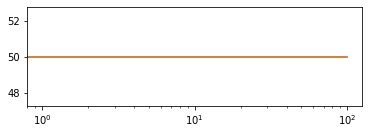

In [33]:
num_epochs = 100
lr = 1
batch_size = 2000

loss, loss_valid, model, y0, y1 = main(num_epochs = num_epochs, lr = lr, batch_size = batch_size, learning_rule = 'backprop')
print(f'Final train loss = {loss[-1]},    valid loss = {loss_valid[-1]} \n')
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(0,num_epochs),loss)
plt.plot(np.arange(0,num_epochs),loss_valid)
ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y0,alpha=0.5)
plt.hist(y1,alpha=0.5)
plt.show()

# plt.scatter(y0,y1)



In [ ]:
num_epochs = 50
lr = 1e-4
batch_size = 100

model.readout.readout_layer.bias.requires_grad = False
loss, loss_valid, model, y0, y1 = main(num_epochs = num_epochs, lr = lr, batch_size = batch_size, learning_rule = 'global_gain', model = model)
print(f'Final train loss = {loss[-1]},    valid loss = {loss_valid[-1]} \n')
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.arange(0,num_epochs),loss)

plt.plot(np.arange(0,num_epochs),loss_valid)
ax.set_xscale('log')
# ax.set_yscale('log')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# plt.imshow(model.readout.readout_layer.weight.detach())

# plt.scatter(torch.cat((model.sensory_pop.sensory_neurons_1.linear.weight,model.sensory_pop.sensory_neurons_2.linear.weight),dim=0).detach(),
#             model.readout.readout_layer.weight[0,:].detach())
print(model.readout.readout_layer.bias)


plt.scatter(model.sensory_pop.sensory_neurons_1.linear.weight.detach(),
            model.readout.readout_layer.weight[0,0:10].detach(),color='r')
plt.scatter(model.sensory_pop.sensory_neurons_2.linear.weight.detach(),
            model.readout.readout_layer.weight[0,10:100].detach(),color='b')
plt.ylabel('readout weight',fontsize=15)
plt.xlabel('sigmoid weight',fontsize=15)
plt.grid('both')
plt.savefig('/Users/shahab/Desktop/Figs/VPL/sigW_vs_readW.png')
plt.show()
# plt.scatter(torch.cat((model.sensory_pop.sensory_neurons_1.linear.bias,model.sensory_pop.sensory_neurons_2.linear.bias),dim=0).detach(),
#             model.readout.readout_layer.weight[0,:].detach())
plt.scatter(model.sensory_pop.sensory_neurons_1.linear.bias.detach(),
            model.readout.readout_layer.weight[0,0:10].detach(),color='r')
plt.scatter(model.sensory_pop.sensory_neurons_2.linear.bias.detach(),
            model.readout.readout_layer.weight[0,10:100].detach(),color='b')
plt.ylabel('readout weight',fontsize=15)
plt.xlabel('sigmoid bias',fontsize=15)
plt.grid('both')
plt.savefig('/Users/shahab/Desktop/Figs/VPL/sigB_vs_readW.png')
plt.show()

In [ ]:
# lr = 1e-4, coh = 0.04-0.06
pre_bias_1 = np.array([-433/1000, -425/1000, -435/1000, 0/1000, -384/1000])
post_bias_1 = np.array([0/1000, 66/1000, 521/1000, 371/1000, 0/1000])

# lr = 1e-4, coh = 0.02-0.04
pre_bias_3 = np.array([-1000/1000,-1000/1000, -1000/1000])
post_bias_3 = np.array([1000/1000, 919/1000,983/1000, ])



import matplotlib.pyplot as plt

plt.subplot()
plt.bar(1,pre_bias_1.mean(),alpha=0.5,width=0.3,color='b')
plt.errorbar(1,pre_bias_1.mean(),xerr=0,yerr=pre_bias_1.std(),marker='o',color='b')
plt.bar(2,post_bias_1.mean(),alpha=0.5,width=0.3,color='b')
plt.errorbar(2,post_bias_1.mean(),xerr=0,yerr=post_bias_1.std(),marker='o',color='b')
plt.xticks([1,2],('pre','post'),fontsize=20)
plt.ylabel('bias',fontsize = 20)
plt.show()

plt.bar(1,pre_bias_2.mean(),alpha=0.5,width=0.3,color='b')
plt.errorbar(1,pre_bias_2.mean(),xerr=0,yerr=pre_bias_2.std(),marker='o',color='b')
plt.bar(2,post_bias_2.mean(),alpha=0.5,width=0.3,color='b')
plt.errorbar(2,post_bias_2.mean(),xerr=0,yerr=post_bias_2.std(),marker='o',color='b')
plt.xticks([1,2],('pre','post'),fontsize=2)
plt.ylabel('bias',fontsize = 20)
plt.show()

plt.bar(1,pre_bias_3.mean(),alpha=0.5,width=0.3,color='b')
plt.errorbar(1,pre_bias_3.mean(),xerr=0,yerr=pre_bias_3.std(),marker='o',color='b')
plt.bar(2,post_bias_3.mean(),alpha=0.5,width=0.3,color='b')
plt.errorbar(2,post_bias_3.mean(),xerr=0,yerr=post_bias_3.std(),marker='o',color='b')
plt.xticks([1,2],('pre','post'),fontsize=2)
plt.ylabel('bias',fontsize = 20)
plt.show()

plt.bar(1,pre_bias_4.mean(),alpha=0.5,width=0.3,color='b')
plt.errorbar(1,pre_bias_4.mean(),xerr=0,yerr=pre_bias_4.std(),marker='o',color='b')
plt.bar(2,post_bias_4.mean(),alpha=0.5,width=0.3,color='b')
plt.errorbar(2,post_bias_4.mean(),xerr=0,yerr=post_bias_4.std(),marker='o',color='b')
plt.xticks([1,2],('pre','post'),fontsize=2)
plt.ylabel('bias',fontsize = 20)
plt.show()